# Benchmarking

## 1. Prepare working environment

In [1]:
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

In [2]:
!nvidia-smi

Fri Jan  6 19:55:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 522.30       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| N/A   44C    P8     3W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:3C:00.0  On |                  N/A |
|  0%   

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Datasets and visulisation

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.data_info = self.get_img_info(data_dir)
        self.transforms = transforms

    def __getitem__(self, item):
        path_img, label = self.data_info.iloc[item][:2]
        label = int(label)
        path_img = os.path.join(self.data_dir, path_img)
        image = Image.open(path_img).convert('RGB')
        # 使用定义好的transforms，对数据进行处理
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.data_info)
    
    def get_img_info(self, data_dir):
        path_dir = os.path.join(data_dir, 'label.csv')
        return pd.read_csv(path_dir)

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = MyDataset("data/dataset02", transform)
testset = trainset

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)

classes = (0, 1)

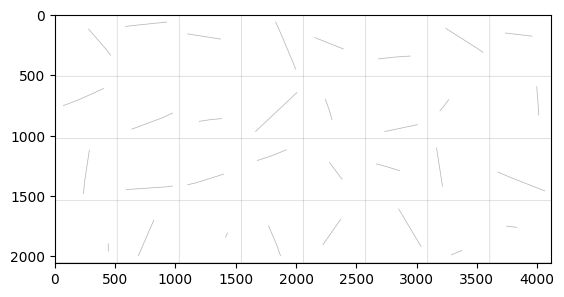

    1     1     0     1     1     1     1     0     1     1     1     1     1     0     1     1     1     1     1     1     1     1     1     1     1     1     1     1     0     1     1     1


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))


## 3. Model and training

In [7]:
names = timm.list_models('resnet50', pretrained=True)
names

['resnet50']

In [8]:
from scripts import Worker

for name in names:
    print(name)
    model = timm.create_model(name, num_classes=2, pretrained=True)
    worker = Worker(model, trainloader, testloader, epochs=25)
    worker.train()

resnet50


epoch,train_loss,valid_loss,accuracy,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 24.00 GiB total capacity; 13.73 GiB already allocated; 7.82 GiB free; 13.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 4. Metrics

In [ ]:
# state_dict = torch.load("model_2023-01-04 13:05:46.085914.pt")

# model = timm.create_model('resnet50', num_classes=10)
# model.load_state_dict(state_dict)

# worker = Worker(model, trainloader, testloader)
worker.eval()

epoch,train_loss,valid_loss,accuracy,time
0,0.474833,0.470528,0.827500,00:13


In [ ]:
from fastai.vision import *
from fastai.data.transforms import *

path_dir = os.path.join("data/dataset01", 'label.csv')
info_df = pd.read_csv(path_dir)
preds = []
for images, labels in iter(testloader):
    # images = images.to(device)
    pred = torch.nn.functional.one_hot(torch.nn.ReLU()(worker.learner.model(images).to(torch.int64)), 2)
    preds += pred
    break    

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
print(preds)

[tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0]]), tensor([[1, 0